In [1]:
from ortools.sat.python import cp_model
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
class TspTw:
    def __init__(self, file: str, base=1000):
        self.base = base

        with open(input_file, "r") as file:
            self.num_nodes = int(next(file).rstrip("\n"))
            self.depot = 0

            self.service_times = []
            self.distance_matrix = [[0.0 for _ in range(self.num_nodes)] for _ in range(self.num_nodes)]
            for i in range(self.num_nodes):
                words = next(file).rstrip("\n").split()
                service_time = float(words[i])
                self.service_times.append(service_time)
                for j in range(self.num_nodes):
                    self.distance_matrix[i][j] = float(words[j])

            # time matrix には出発地点の service time が含まれている
            for i in range(self.num_nodes):
                for j in range(self.num_nodes):
                    self.distance_matrix[i][j] -= self.service_times[i]

            self.time_windows = []
            for i in range(self.num_nodes):
                words = next(file).rstrip("\n").split()
                self.time_windows.append((int(words[0]), int(words[1])))

    @property
    def nodes(self) -> list[int]:
        return list(range(self.num_nodes))
        
    def scaled_dist(self, i, j) -> int:
        return int(self.distance_matrix[i][j] * self.base)

    def scaled_tw(self, i) -> int:
        st, ed = self.time_windows[i]
        return (int(st * self.base), int(ed * self.base))

    def scaled_st(self, i) -> int:
        return int(self.service_times[i] * self.base)

In [3]:
class Model:
    def __init__(self, tsp: TspTw):
        self.model = cp_model.CpModel()
        self.solver = cp_model.CpSolver()

        # 変数定義
        time_ub = sum(tsp.scaled_dist(i, j) for j in tsp.nodes for i in tsp.nodes) + sum(tsp.scaled_st(i) for i in tsp.nodes)
        self.x = [[self.model.new_bool_var(f"{i} to {j}") for j in tsp.nodes] for i in tsp.nodes]
        self.arrives = [self.model.new_int_var(0, time_ub, f"time arrive to node {i}") for i in tsp.nodes]
        self.leaves = [self.model.new_int_var(0, time_ub, f"time leave from node {i}") for i in tsp.nodes]

        for i in tsp.nodes:
            self.model.add(self.x[i][i] == 0)
            self.model.add_exactly_one([self.x[i][j] for j in tsp.nodes if i != j])
            self.model.add_exactly_one([self.x[j][i] for j in tsp.nodes if i != j])

            # Time window 開始時刻より前に到着してもよい
            # Time window 終了時刻を過ぎてから出発してもよい
            # ただし time window 枠内にサービス時間分だけ留まらなければならない
            tw_start, tw_end = tsp.scaled_tw(i)
            self.model.add(self.leaves[i] - tw_start >= tsp.scaled_st(i))
            if i != tsp.depot:
                self.model.add(tw_end - self.arrives[i] >= tsp.scaled_st(i))
                self.model.add(self.leaves[i] - self.arrives[i] >= tsp.scaled_st(i))

            # 移動時間に関する制約
            for j in tsp.nodes:
                if j != i:
                    self.model.add(self.leaves[i] + tsp.scaled_dist(i, j) * self.x[i][j] <= self.arrives[j] + time_ub * (1 - self.x[i][j]))

        self.model.minimize(self.arrives[0])
        # self.model.minimize(sum(tsp.dist1000int(i, j) * self.x[i][j] for i in tsp.nodes for j in tsp.nodes if i != j))

    def solve(self, log=True, timelimit=300):
        self.solver.parameters.log_search_progress = log
        self.solver.parameters.max_time_in_seconds = timelimit
        return self.solver.solve(self.model)

In [4]:
input_file = "../data/SolomonPotvinBengio/rc_206.1.txt"
# input_file = "../data/SolomonPotvinBengio/rc_206.3.txt"
# input_file = "../data/Langevin/N20ft301.dat"
# input_file = "../data/Langevin/N40ft201.dat"
# input_file = "../data/Dumas/n200w20.001.txt"
tsp = TspTw(input_file)

In [5]:
print("Distance matrix(scaled)")
for i in tsp.nodes:
    for j in tsp.nodes:
        print(tsp.scaled_dist(i, j), end=' ')
    print()

print("\nService time(scaled)")
print([int(tsp.scaled_st(i)) for i in tsp.nodes])

print("\nTime window(scaled)")
print([tsp.scaled_tw(i) for i in tsp.nodes])

Distance matrix(scaled)
0 43011 36055 33541 
43011 0 7071 11180 
36055 7071 0 5000 
33541 11180 5000 0 

Service time(scaled)
[0, 10000, 10000, 10000]

Time window(scaled)
[(0, 960000), (43000, 283000), (36000, 276000), (33000, 273000)]


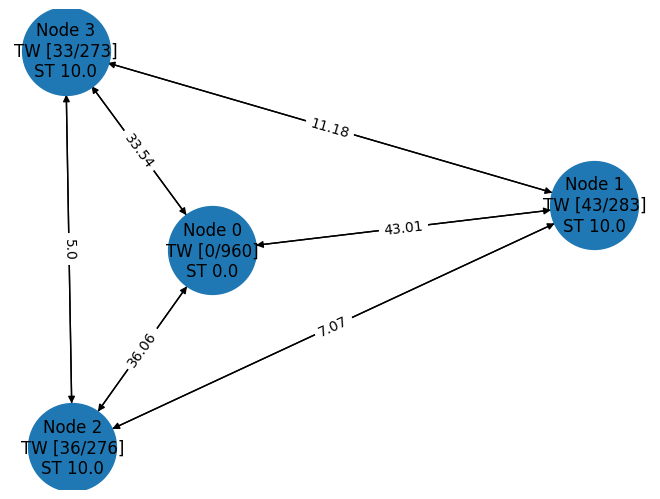

In [6]:
graph = nx.DiGraph()
for i in tsp.nodes:
    for j in tsp.nodes:
        if j >= i:
            continue
        weight = round(tsp.distance_matrix[i][j], 2)
        graph.add_edge(i, j, weight=weight)
        graph.add_edge(j, i, weight=weight)
node_labels = {}
for i in tsp.nodes:
    node_labels[i] = f"Node {i}\nTW [{tsp.time_windows[i][0]}/{tsp.time_windows[i][1]}]\nST {tsp.service_times[i]}"

pos = nx.spring_layout(graph, seed=0)
labels = nx.get_edge_attributes(graph, "weight")
nx.draw(graph, pos, node_size=400*10, labels=node_labels)
nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
plt.show()

In [7]:
model = Model(tsp)
status = model.solve()


Starting CP-SAT solver v9.10.4067
Parameters: max_time_in_seconds: 300 log_search_progress: true
Setting number of workers to 8

Initial optimization model '': (model_fingerprint: 0xcdebb2429ab3cfea)
#Variables: 24 (#ints: 1 in objective)
  - 16 Booleans in [0,1]
  - 8 in [0,301716]
#kExactlyOne: 8 (#literals: 24)
#kLinear1: 11
#kLinear2: 3
#kLinear3: 12

Starting presolve at 0.00s
  1.00e-05s  0.00e+00d  [DetectDominanceRelations] 
  8.20e-05s  0.00e+00d  [PresolveToFixPoint] #num_loops=3 #num_dual_strengthening=2 
  4.00e-06s  0.00e+00d  [ExtractEncodingFromLinear] #potential_supersets=8 
[Symmetry] Graph for symmetry has 50 nodes and 66 arcs.
[Symmetry] Symmetry computation done. time: 9e-06 dtime: 6.96e-06
  1.12e-04s  1.96e-05d  [Probe] #probed=30 #new_bounds=6 #new_binary_clauses=6 
  2.00e-06s  0.00e+00d  [MaxClique] 
  4.00e-06s  0.00e+00d  [DetectDominanceRelations] 
  2.30e-05s  0.00e+00d  [PresolveToFixPoint] #num_loops=2 #num_dual_strengthening=1 
  6.00e-06s  0.00e+00d  [

In [8]:
print("Statistics")
print(f"  status    : {model.solver.status_name(status)}")
print(f"  conflicts : {model.solver.num_conflicts}")
print(f"  branches  : {model.solver.num_branches}")
print(f"  wall time : {model.solver.wall_time} s")
if status == cp_model.OPTIMAL or cp_model.FEASIBLE:
    print(f"  total cost: {model.solver.objective_value / tsp.base}")

Statistics
  status    : OPTIMAL
  conflicts : 4
  branches  : 32
  wall time : 0.0031980000000000003 s
  total cost: 117.847


In [9]:
source = tsp.depot
print(f"Node {source}")
print(f" leave time: {model.solver.value(model.leaves[source]) / tsp.base}")
while True:
    for i in tsp.nodes:
        if model.solver.boolean_value(model.x[source][i]):
            target = i
            break
    print(f"Node {target}")
    print(f" arrive time: {model.solver.value(model.arrives[target]) / tsp.base}")
    if target != tsp.depot:
        print(f" leave time: {model.solver.value(model.leaves[target]) / tsp.base}")
    else:
        break
    source = target

Node 0
 leave time: 0.0
Node 3
 arrive time: 33.541
 leave time: 43.541
Node 1
 arrive time: 54.721
 leave time: 64.721
Node 2
 arrive time: 71.792
 leave time: 81.792
Node 0
 arrive time: 117.847


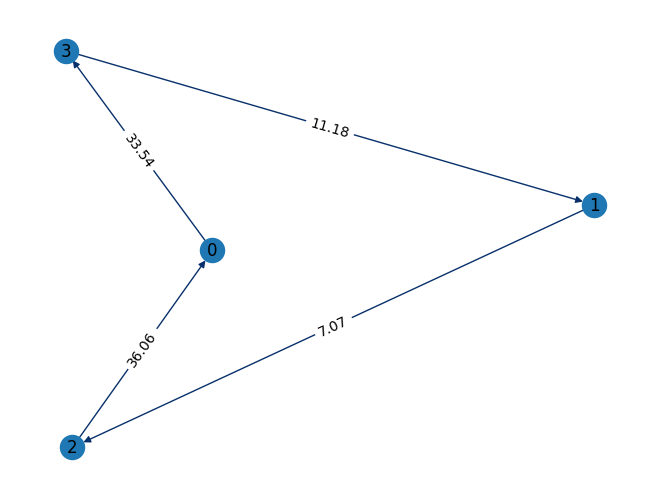

In [10]:
graph = nx.DiGraph()
for i in tsp.nodes:
    for j in tsp.nodes:
        if j >= i:
            continue
        weight = round(tsp.distance_matrix[i][j], 2)
        color_used = 5
        color_notused = 1
        if model.solver.boolean_value(model.x[i][j]):
            # graph.add_edge(j, i, weight=weight, color=color_unused)
            graph.add_edge(i, j, weight=weight, color=color_used)
        elif model.solver.boolean_value(model.x[j][i]):
            # graph.add_edge(i, j, weight=weight, color=color_unused)
            graph.add_edge(j, i, weight=weight, color=color_used)
        # else:
        #     graph.add_edge(i, j, weight=weight, color=color_notused)
        #     graph.add_edge(j, i, weight=weight, color=color_notused)

labels = nx.get_edge_attributes(graph, "weight")
colors = [edge['color'] for edge in graph.edges.values()]

# pos = nx.spring_layout(graph, seed=0) # 上で描画するときに使った pos を再利用する
nx.draw(graph, pos, edge_cmap=plt.cm.Blues, edge_color=colors, edge_vmin=0, edge_vmax=5)
nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
nx.draw_networkx_labels(graph, pos)
# nx.draw(graph, pos, node_size=20, edge_cmap=plt.cm.Blues, edge_color=colors, edge_vmin=0, edge_vmax=5)
# nx.draw_networkx_edge_labels(graph, pos, edge_labels={})
# nx.draw_networkx_labels(graph, pos, labels={})
plt.show()